In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 8.1

In [3]:
df = pd.read_csv('./data/rugged.csv', sep=';')
df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [4]:
df['log_gdp'] = np.log(df['rgdppc_2000'])  # Log version of outcome
df[['rgdppc_2000', 'log_gdp']].head()

,rgdppc_2000,log_gdp
0,NaN,NaN
1,NaN,NaN
2,1794.729,7.492609
3,NaN,NaN
4,3703.113,8.216929


In [5]:
ddf = df[~np.isnan(df['log_gdp'].values)].copy()

ddf['log_gdp_std'] = ddf['log_gdp'] / np.mean(ddf['log_gdp'])
ddf['rugged_std'] = ddf['rugged'] / np.max(ddf['rugged'])

ddf[['log_gdp_std', 'rugged_std']]

,log_gdp_std,rugged_std
2,0.879712,0.138342
4,0.964755,0.552564
7,1.166270,0.123992
8,1.104485,0.124960
9,0.914904,0.433409
...,...,...
229,0.996681,0.270397
230,0.783032,0.374557
231,1.074365,0.283941
232,0.780967,0.085940


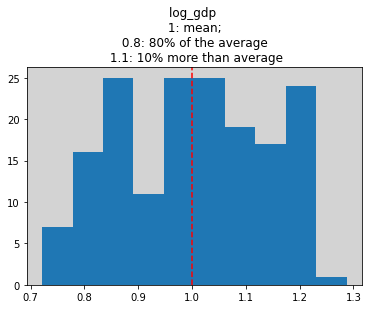

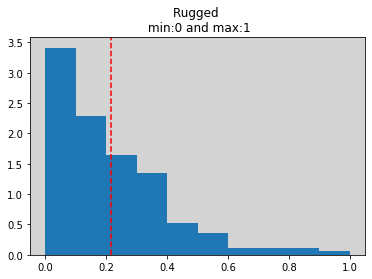

In [6]:
plt.hist(ddf['log_gdp_std'])
plt.title('log_gdp \n 1: mean; \n 0.8: 80% of the average \n 1.1: 10% more than average')
plt.axvline(x=1, c='r', ls='--')
plt.show()

plt.hist(ddf['rugged_std'], density=True)
plt.title('Rugged \n min:0 and max:1')
plt.axvline(x=np.mean(ddf['rugged_std']), c='r', ls='--')
plt.show()

### R Code 8.2

In [7]:
model = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        real rugged_std_average;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta * (rugged_std - rugged_std_average);
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;  // By default, if a variable log_lik is present in the Stan model, it will be retrieved as pointwise log likelihood values.
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s


/home/rodolpho/.cache/httpstan/4.9.1/models/nkcukuhk/model_nkcukuhk.cpp: In instantiation of ‘void model_nkcukuhk_namespace::model_nkcukuhk::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/nkcukuhk/model_nkcukuhk.cpp:508:69:   required from here
/home/rodolpho/.cache/httpstan/4.9.1/models/nkcukuhk/model_nkcukuhk.cpp:310:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  310 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 14.8s
Building: 14.9s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building

Building: 36.0s, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_po72hdl0/model_nkcukuhk.stan', line 29, column 8 to column 40)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model 

In [8]:
# Transform to dataframe pandas
df_samples = samples.to_frame()
df_samples.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_gdp_std_hat.161,log_gdp_std_hat.162,log_gdp_std_hat.163,log_gdp_std_hat.164,log_gdp_std_hat.165,log_gdp_std_hat.166,log_gdp_std_hat.167,log_gdp_std_hat.168,log_gdp_std_hat.169,log_gdp_std_hat.170
draws,,,,,,,,,,,,,,,,,,,,,
0,248.313260,0.886161,0.829903,2.0,3.0,0.0,-246.915311,1.011708,-0.081775,0.151394,...,1.035327,0.813376,1.125644,1.285891,0.818713,1.038937,1.013380,1.062554,1.238620,0.971679
1,248.823509,0.881723,0.773226,1.0,1.0,0.0,-248.633097,0.982331,0.077477,0.133841,...,1.042534,1.137617,0.921318,1.072259,0.806378,0.892900,1.045496,0.980573,0.942307,1.041391
2,250.913784,0.902023,0.767185,2.0,3.0,0.0,-244.372630,0.992865,-0.024583,0.140416,...,0.811115,1.007899,0.953007,1.022288,0.896778,1.086428,1.226970,0.985490,1.082139,0.828433
3,250.813655,0.994901,0.764031,3.0,7.0,0.0,-250.131413,0.997290,-0.039013,0.132230,...,0.976771,1.008322,0.887366,1.276711,1.219901,0.933449,1.074895,0.949093,0.929125,0.810078
4,250.579148,0.994620,0.829903,2.0,3.0,0.0,-248.087351,1.006409,-0.008948,0.145378,...,0.700623,1.127113,1.198382,0.808135,0.859510,0.909396,0.570011,1.197513,1.199203,0.899221


In [9]:
# stan_fit to arviz_stan

stan_data = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
)

In [10]:
stan_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

In [11]:
az.summary(stan_data, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.011,0.980,1.020,0.000,0.000,4053.0,2688.0,1.0
beta,0.001,0.056,-0.103,0.106,0.001,0.001,3722.0,2698.0,1.0
sigma,0.138,0.008,0.124,0.152,0.000,0.000,3806.0,2753.0,1.0


### R Code 8.3

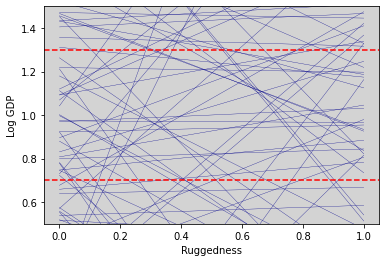

In [12]:
alpha = np.random.normal(1, 1, 1000)
beta = np.random.normal(0, 1, 1000)

rugged_seq = np.linspace(0, 1, 100)

for i in range(100):
    plt.plot(rugged_seq, alpha[i] + beta[i] * rugged_seq, c='darkblue', lw=0.3)
    
plt.axhline(y=1.3, c='r', ls='--')    
plt.axhline(y=0.7, c='r', ls='--')    
    
plt.ylim((0.5, 1.5))
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

plt.show()

### R Code 8.4

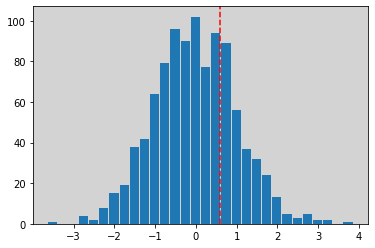

In [13]:
plt.hist(beta, bins=30, rwidth=0.9)
plt.axvline(x=0.6, c='r', ls='--')
plt.show()

In [14]:
np.sum(np.sum(beta > 0.6) / len(beta))

0.278

### R Code 8.5

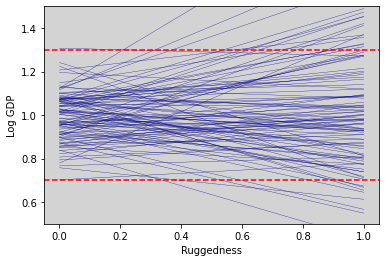

In [15]:
alpha = np.random.normal(1, 0.1, 1000)
beta = np.random.normal(0, 0.3, 1000)

rugged_seq = np.linspace(0, 1, 100)

for i in range(100):
    plt.plot(rugged_seq, alpha[i] + beta[i] * rugged_seq, c='darkblue', lw=0.3)
    
plt.axhline(y=1.3, c='r', ls='--')    
plt.axhline(y=0.7, c='r', ls='--')    

plt.ylim((0.5, 1.5))
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

plt.show()

In [16]:
model2 = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        real rugged_std_average;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta * (rugged_std - rugged_std_average);
    
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 0.1);
        beta ~ normal(0, 0.3);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;  // By default, if a variable log_lik is present in the Stan model, it will be retrieved as pointwise log likelihood values.
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
}

posteriori = stan.build(model2, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_mnq_xs5k/model_n35f33ah.stan', line 30, column 8 to column 40)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then yo

In [17]:
stan_data2 = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
)

In [18]:
az.summary(stan_data, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.011,0.980,1.020,0.000,0.000,4053.0,2688.0,1.0
beta,0.001,0.056,-0.103,0.106,0.001,0.001,3722.0,2698.0,1.0
sigma,0.138,0.008,0.124,0.152,0.000,0.000,3806.0,2753.0,1.0


### R Code 8.7

In [19]:
ddf['cid'] = [1 if cont_africa == 1 else 2 for cont_africa in ddf['cont_africa']]
ddf[['cont_africa', 'cid']].head()

,cont_africa,cid
2,1,1
4,0,2
7,0,2
8,0,2
9,0,2


### R Code 8.8

In [20]:
model3 = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        array[N] int cid;  // Must be integer because this is index to alpha.
        real rugged_std_average;
    }
    
    parameters {
        real alpha[2];  //Can be used to real alpha[2] or array[2] int alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        for (i in 1:N){
            mu[i] = alpha[ cid[i] ] + beta * (rugged_std[i] - rugged_std_average);
        }
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 0.1);
        beta ~ normal(0, 0.3);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
    'cid': ddf['cid'].values,
}

posteriori = stan.build(model3, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_zj15gmz4/model_f62hjfuw.stan', line 11, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition

In [21]:
stan_data3 = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
)

### R Code 8.9

In [23]:
models_8 = { 'm8.1': stan_data2, 'm8.2': stan_data3 }

az.compare(models_8, ic='waic')

/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,126.192360,4.075589,0.000000,0.969907,7.399608,0.000000,True,log
m8.1,1,94.461509,2.541551,31.730851,0.030093,6.503045,7.315649,False,log


### R Code 8.10

In [22]:
az.summary(stan_data3, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.881,0.016,0.852,0.913,0.000,0.000,4612.0,2791.0,1.0
alpha[1],1.049,0.010,1.031,1.070,0.000,0.000,4661.0,3082.0,1.0
beta,-0.047,0.046,-0.134,0.042,0.001,0.001,4579.0,3062.0,1.0
sigma,0.114,0.006,0.103,0.126,0.000,0.000,3857.0,3043.0,1.0
